## Validating interpolated flood estimates

***About this notebook:*** This code is used to validate the polynomial and Gaussian flooding estimates against the key informant data, GLOFAS water discharge data, and FFWC water level data. 

***Inputs:*** 1) .csv file with interpolated flood fraction results 2) .xlsx file with key informant data 3) .csv file with GLOFAS data 4) .xls with FFWC data

***Outputs:*** Figures to demonstrate results

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import shapely

In [2]:
os.chdir('..')

In [3]:
# Read in the data
df_interview = pd.read_excel('data/raw/Informant_data/Sentinel-1-BGD-Flooding_INTERVIEW.xlsx', sheet_name='Sheet1_COPY')
df_interp = pd.read_csv('data/processed/ADM4_flood_extent_interpolated.csv')

### Comparing against informant interviews

In [4]:
# Drop rows where no informant interviews
df_interview = df_interview.dropna(subset=['Interview_1', 'Interview_2', 'Interview_3'], thresh=1)

# Calculate mean when multiple interviews for the same union
df_interview['Interview_mean'] = df_interview[['Interview_1','Interview_2', 'Interview_3']].mean(axis=1)
df_interview['Interview_mean'] = df_interview['Interview_mean']/100

# Select columns of interest
df_interview = df_interview[['ADM4_EN', 'ADM4_PCODE', 'date', 'flood_fraction', 'Interview_mean']]

# Get list of the unions with interviews 
sampled_unions = df_interview['ADM4_PCODE'].unique()

# Get subset of interpolated data based on where interview sampling has been done 
df_interp = df_interp[df_interp['PCODE'].isin(sampled_unions)]

# Convert to datetime format
df_interp['DATE'] = pd.to_datetime(df_interp['DATE'], format = '%d/%m/%Y').dt.strftime("%Y-%m-%d")
df_interview['date'] = pd.to_datetime(df_interview['date'], format = "%Y-%m-%d").dt.strftime("%Y-%m-%d")

In [5]:
# Merge the interpolated and the interview data
df_interp_interview = df_interp.merge(df_interview, how='outer', left_on=(['PCODE', 'DATE']), right_on=(['ADM4_PCODE', 'date']))
df_interp_interview = df_interp_interview[['PCODE', 'DATE', 'Interview_mean', 'FLOOD_EXTENT_G']]

In [6]:
# Process for visualization
df_ii_long = df_interp_interview.melt(id_vars=['DATE', 'PCODE'])

In [7]:
# Mask to keep time range within July
mask = (df_ii_long['DATE'] > '2020-07-01') & (df_ii_long['DATE'] <= '2020-07-31')
df_ii_long = df_ii_long.loc[mask]

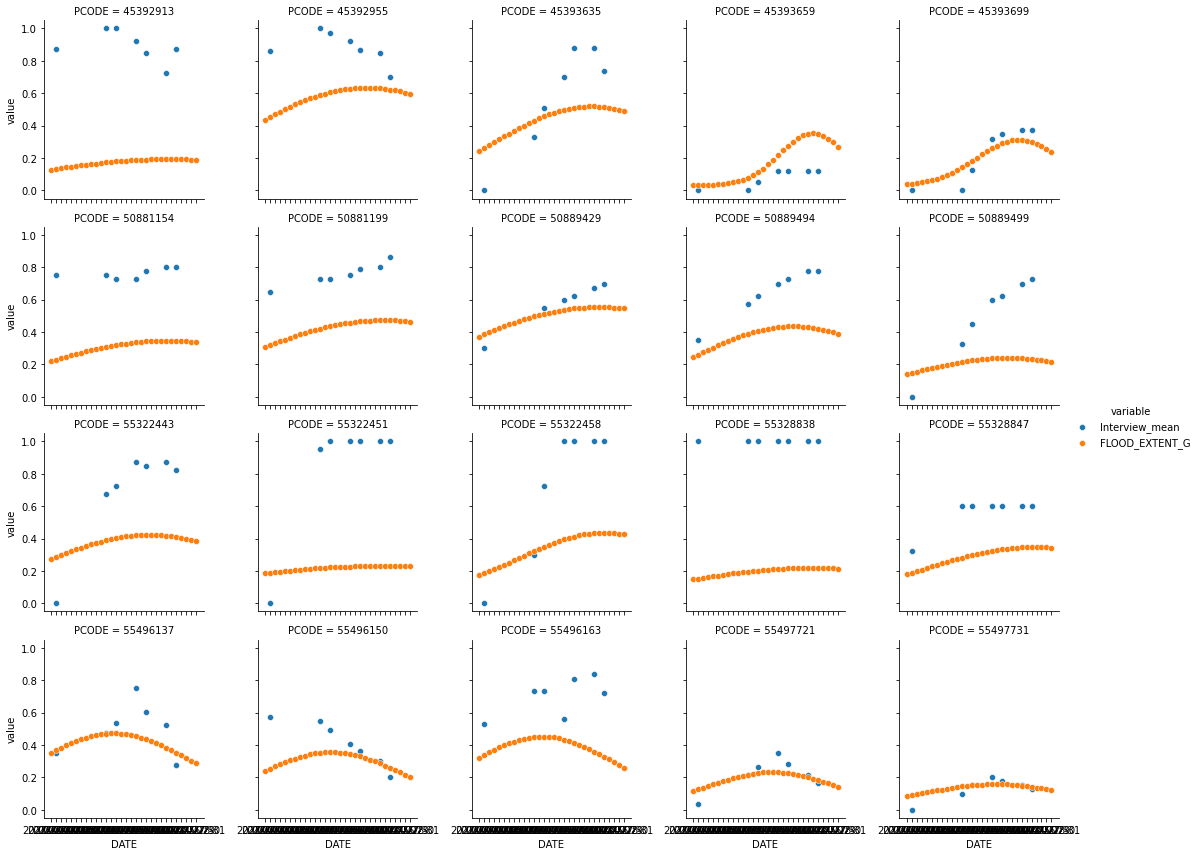

In [8]:
# Create facet grid with results
g = sns.FacetGrid(df_ii_long, col="PCODE", hue='variable', col_wrap=5)
g.map(sns.scatterplot, "DATE", "value")
g.add_legend()
g.savefig("results/interview_interp.png")

### Comparing against GLOFAS data

In [9]:
df_glofas = pd.read_csv('data/raw/GLOFAS_data/2020.csv')
df_interp_2 = pd.read_csv('data/processed/ADM4_flood_extent_interpolated.csv')

In [10]:
# Read in shp and select area of interest
shp = gpd.read_file('data/processed/Shapefiles/bdg_shp/bgd_admbnda_adm4_bbs_20180410.shp')
shp = shp[shp['ADM2_EN'].isin(['Bogra', 'Gaibandha', 'Jamalpur', 'Kurigram', 'Sirajganj'])]
stations = gpd.read_file('data/processed/Shapefiles/stations.shp')

In [11]:
# Format the list of stations coordinates into a geodataframe
#stations = pd.DataFrame.from_dict(stations_coord, orient='index',
#                       columns=['Lon', 'Lat'])
#stations.reset_index(level=0, inplace=True) # Resets the index, makes factor a column
#stations = gpd.GeoDataFrame(
#    stations, geometry=gpd.points_from_xy(stations.Lon, stations.Lat))

In [12]:
# Spatial join between stations and admin areas
joined = gpd.sjoin(stations, shp, how="inner", op='intersects')
joined = joined[['Station', 'ADM4_EN', 'ADM4_PCODE']]

# Rename columns
df_glofas.columns = ['date', 'Noonkhawa', 'Chilmari', 'Bahadurabad', 'Sariakandi', 'Kazipur', 'Serajganj', 'Aricha']

# Melt
df_glofas = df_glofas.melt(id_vars=(['date']))

# Rename again
df_glofas.columns = ['date', 'Station', 'Discharge']

In [13]:
# Create dict to map between station name and admin4 pcode 
station_admin4 = dict(zip(joined.Station, joined.ADM4_PCODE))

In [14]:
# Create new column in glofas data with admin4 pcode
df_glofas['ADM4_PCODE'] = df_glofas['Station'].map(station_admin4)

# Drop stations not within aoi
df_glofas = df_glofas.dropna()

# Convert types for merge
df_glofas['ADM4_PCODE'] = df_glofas['ADM4_PCODE'].astype('int64')

In [15]:
# Convert date format
df_interp_2['DATE'] = pd.to_datetime(df_interp_2['DATE'], format = '%d/%m/%Y').dt.strftime("%Y-%m-%d")

In [16]:
# Merge dataframes and reduce columns 
df_glofas_interp = df_glofas.merge(df_interp_2, how='inner', left_on=['ADM4_PCODE', 'date'], right_on=['PCODE', 'DATE'])
df_glofas_interp = df_glofas_interp[['Station', 'Discharge', 'PCODE', 'FLOOD_EXTENT_G', 'FLOOD_EXTENT_P', 'DATE']]
df_glofas_interp.columns = ['Station', 'Discharge', 'PCODE', 'Flood extent (Gaussian)', 'FLOOD_EXTENT_P', 'Date']

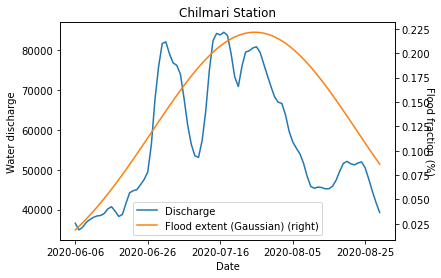

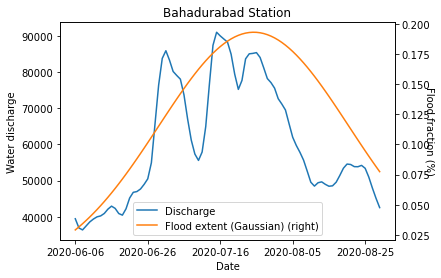

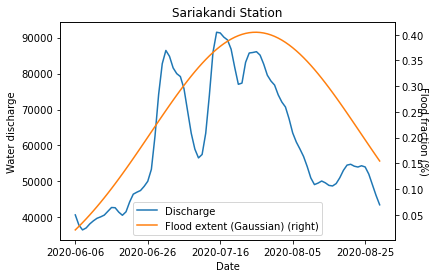

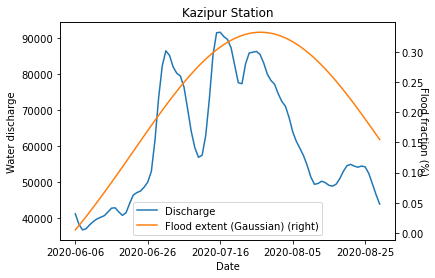

In [17]:
# Create the plots 
for selected in df_glofas_interp['PCODE'].unique():
    df_selected = df_glofas_interp.loc[df_glofas_interp['PCODE'] == selected].reset_index()
    
    discharge_max = df_selected.loc[df_selected['Discharge'].argmax(),:]['Date']
    gaus_max = df_selected.loc[df_selected['Flood extent (Gaussian)'].argmax(),:]['Date']
    
    ax = df_selected.plot('Date','Discharge')
    ax.set_ylabel('Water discharge', fontsize=10)
    df_selected.plot('Date','Flood extent (Gaussian)',secondary_y=True, ax=ax)
    plt.title(df_selected['Station'][0] + ' Station')
    plt.ylabel('Flood fraction (%)', fontsize=10, rotation=-90)
    plt.savefig("results/{}_waterdischarge.png".format(df_selected['PCODE'][1]), bbox_inches='tight', pad_inches=0.2)

### Comparing against FFWC data

In [18]:
# Read and process ffwc data - take the mean of all measurements for a day
df_ffwc = pd.read_excel('data/raw/FFWC_data/FFWC_data.xls')
df_ffwc['DateTime'] = pd.to_datetime(df_ffwc['DateTime'], format = '%Y-%m-%d %H:%M:%S').dt.strftime("%Y-%m-%d")

# Get the additional Sariakandi data
df_ffwc_saria = pd.read_csv('data/raw/FFWC_data/Sariakandi_WL_June_Sep_2020.csv')
df_ffwc_saria['StationName'] = 'Sariakandi'
df_ffwc_saria = df_ffwc_saria[1:]
df_ffwc_saria.columns = ['DateTime', 'WL(m)', 'StationName']
df_ffwc_saria['DateTime'] = pd.to_datetime(df_ffwc_saria['DateTime'], format = '%Y-%m-%d %H:%M:%S').dt.strftime("%Y-%m-%d")

# Get the additional Bhadurbad data
df_ffwc_bhad = pd.read_csv('data/raw/FFWC_data/SW46.9L_19-11-2020.csv')
df_ffwc_bhad['StationName'] = 'Bahadurabad'
df_ffwc_bhad['DateTime'] = pd.to_datetime(df_ffwc_bhad['DateTime'], format = '%m/%d/%Y %H:%M:%S').dt.strftime("%Y-%m-%d")

# Match spelling with the glofas
#df_ffwc['StationName'] = df_ffwc['StationName'].replace('Shariakandi', 'Sariakandi')

# Join the three files 
df_ffwc = df_ffwc.append([df_ffwc_saria, df_ffwc_bhad])

In [19]:
# Convert date format
#df_ffwc['date'] = pd.to_datetime(df_ffwc['date'], format = '%Y-%m-%d').dt.strftime("%Y-%m-%d")
df_ffwc['DateTime'] = pd.to_datetime(df_ffwc['DateTime'])
df_ffwc['Day'] = df_ffwc['DateTime'].dt.date

# Get the mean of measurements from a single day
df_ffwc = df_ffwc[['StationName', 'WL(m)', 'DateTime']]
df_ffwc['WL(m)'] = pd.to_numeric(df_ffwc['WL(m)'])
df_ffwc = df_ffwc.groupby(by=['StationName', 'DateTime']).mean()
df_ffwc['DateTime'] = df_ffwc.droplevel(0).index
df_ffwc = df_ffwc.droplevel(1).reset_index()

# Create new column in ffwc data with admin4 pcode
df_ffwc['ADM4_PCODE'] = df_ffwc['StationName'].map(station_admin4)

# Drop stations not within aoi
df_ffwc = df_ffwc.dropna()

# Convert types for merge
df_ffwc['ADM4_PCODE'] = df_ffwc['ADM4_PCODE'].astype('int64')
df_ffwc['DateTime'] = pd.to_datetime(df_ffwc['DateTime'])
df_interp_2['DATE'] = pd.to_datetime(df_interp_2['DATE'])

# Merge dataframes and reduce columns 
df_ffwc_interp = df_ffwc.merge(df_interp_2, how='inner', left_on=['ADM4_PCODE', 'DateTime'], right_on=['PCODE', 'DATE'])
df_ffwc_interp = df_ffwc_interp[['StationName', 'WL(m)', 'PCODE', 'FLOOD_EXTENT_G', 'FLOOD_EXTENT_P', 'DATE']]
df_ffwc_interp.columns = ['StationName', 'Water level', 'PCODE', 'Flood extent (Gaussian)', 'FLOOD_EXTENT_P', 'Date']

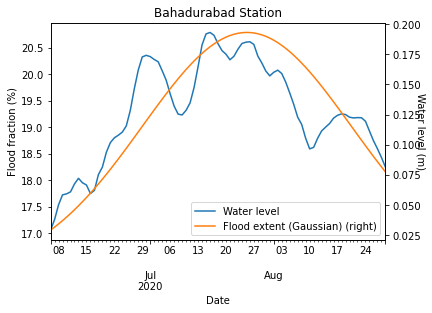

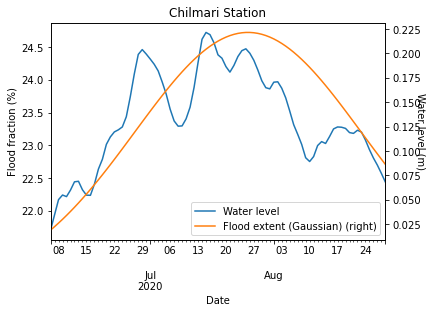

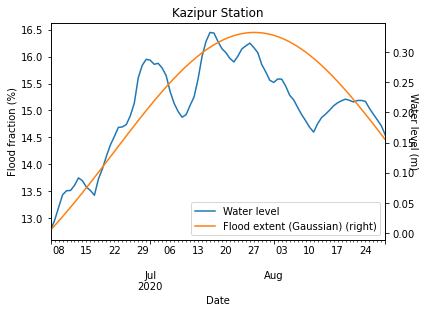

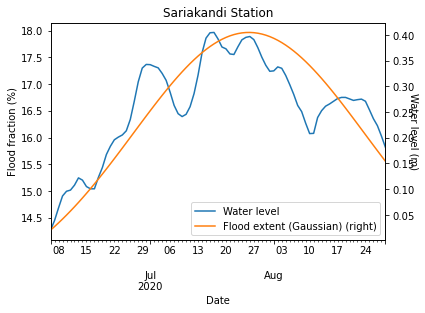

In [20]:
# Create the plots 
for selected in df_ffwc_interp['PCODE'].unique():
    df_selected = df_ffwc_interp.loc[df_ffwc_interp['PCODE'] == selected].reset_index()
    ax = df_selected.plot('Date','Water level')
    ax.set_ylabel('Flood fraction (%)', fontsize=10);
    df_selected.plot('Date','Flood extent (Gaussian)',secondary_y=True, ax=ax)
    plt.title(df_selected['StationName'][0] + ' Station')
    plt.ylabel('Water level (m)', fontsize=10, rotation=-90)
    plt.savefig("results/{}_waterlevel.png".format(df_selected['PCODE'][1]), bbox_inches='tight', pad_inches=0.2)